In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 500
number_of_features = 41
number_of_class_attack_cat = 10
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

Axes(0.125,0.11;0.775x0.77)
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64
6    93000
5    58871
3    44525
4    24246
2    16353
7    13987
0     2677
1     2329
8     1511
9      174
Name: attack_cat, dtype: int64


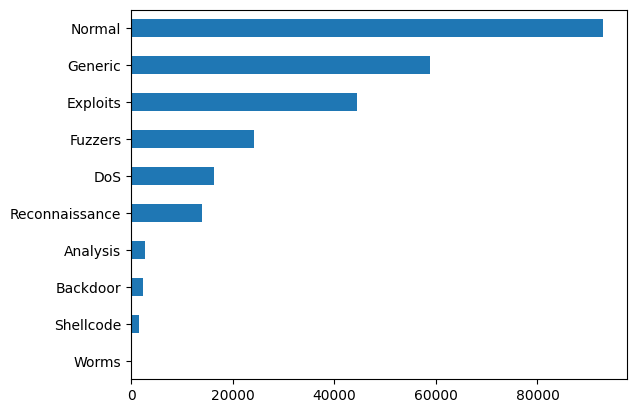

In [5]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=dataset_attack_cat ,batch_size=batch_size ,shuffle=True)


Axes(0.22375,0.11;0.5775x0.77)


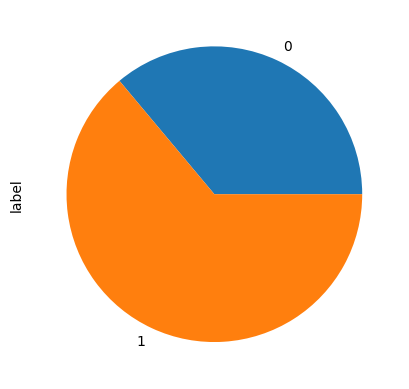

In [6]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3) # 30
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3) #70
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=dataset_label ,batch_size=batch_size ,shuffle=True)

# **preprocessing ended**

# **create model**

In [7]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [8]:
my_model_attack = Model_Attack_Cat().to(device=device)
my_model_attack

Model_Attack_Cat(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [9]:
my_model_label = Model_Label().to(device=device)
my_model_label

Model_Label(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)

# **optimizer and loss function**

In [10]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=lr)
optimizer2 = opt.Adam(params=my_model_label.parameters(),lr=lr)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

In [12]:
my_model_attack.load_state_dict(torch.load("/content/model_attack.pth"))

<All keys matched successfully>

# **test attack cat**

In [14]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / len(dataset_attack_cat)),end="")
print("%")

acc : 82.00%


Confusion matrix, without normalization
[[   69     7     0     5     1    12    75     5     0     0]
 [    0   954    76   113    31   138   149    49     1     0]
 [    1  2761  7468   584     7   206  2736   217     7     0]
 [    2   158   101 87437    19  4688   520    55     2    18]
 [    1    39     8    48 57948    77   632   109     8     1]
 [    3   130    93  6664    28 14864  2266   184    14     0]
 [   33   208   819   940   164  1000 39736  1576    47     2]
 [    4   151   104   146    75   380 13027  2452    12     2]
 [    0    23    18    11     5   276  1653   160   183     0]
 [    0     0     0   369     1   262  1714   148     0   183]]


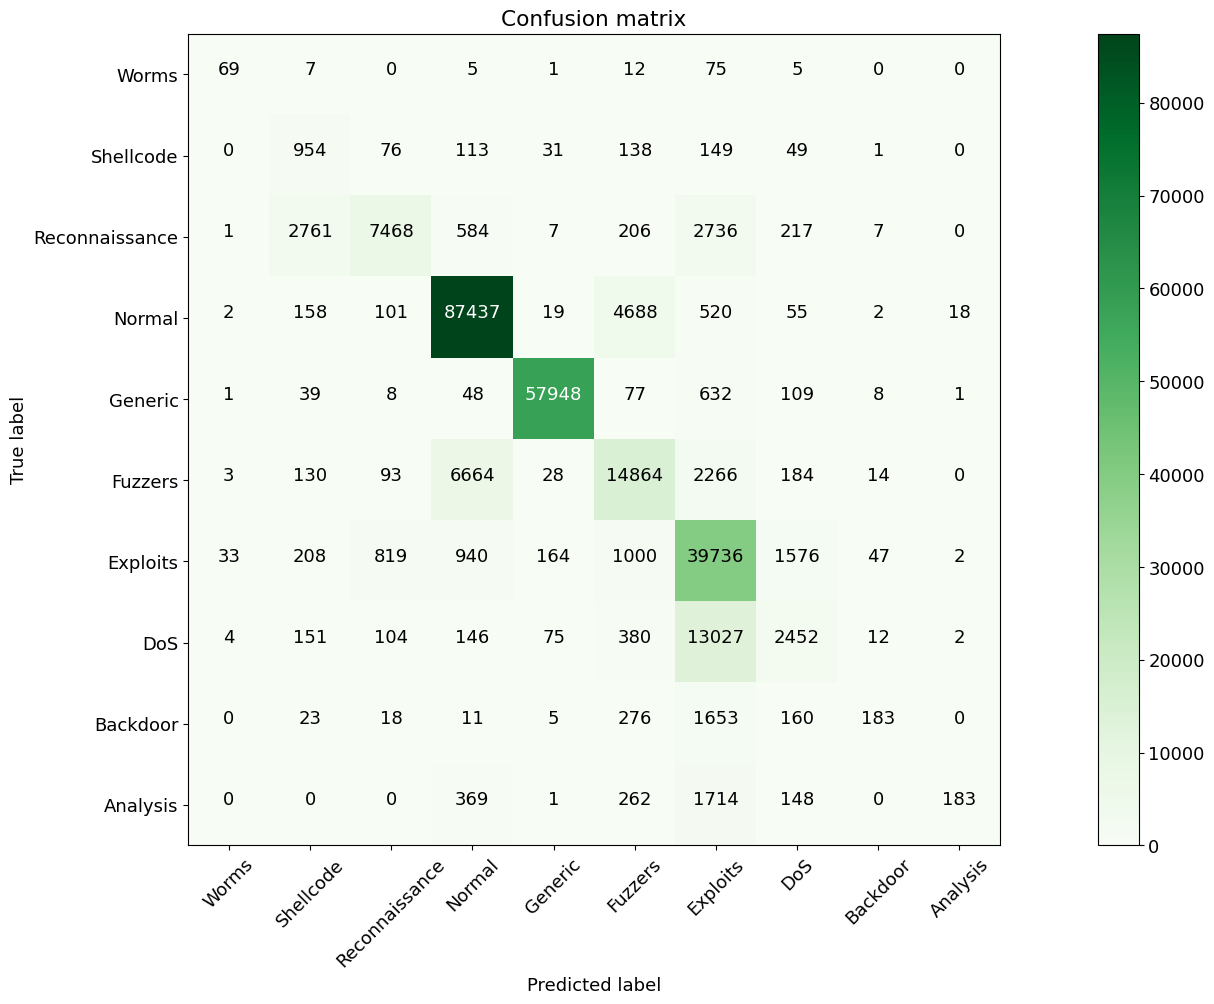

In [15]:
plt.rcParams.update({'font.size': 13})

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[9,8,7,6,5,4,3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['Worms','Shellcode','Reconnaissance','Normal','Generic','Fuzzers','Exploits','DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [16]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.89      0.07      0.13      2677
           1       0.67      0.08      0.14      2329
           2       0.49      0.15      0.23     16353
           3       0.64      0.89      0.74     44525
           4       0.68      0.61      0.64     24246
           5       0.99      0.98      0.99     58871
           6       0.91      0.94      0.92     93000
           7       0.86      0.53      0.66     13987
           8       0.22      0.63      0.32      1511
           9       0.61      0.40      0.48       174

    accuracy                           0.82    257673
   macro avg       0.70      0.53      0.53    257673
weighted avg       0.82      0.82      0.80    257673



# **train label**

In [17]:
my_model_label.load_state_dict(torch.load("/content/model_label.pth"))

<All keys matched successfully>

# **test label**

In [19]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_label_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_label(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)    

print("acc : %.2f" % (100.*correct / len(dataset_label)),end="")
print("%")

acc : 94.69%


Confusion matrix, without normalization
[[155865   8808]
 [  4874  88126]]


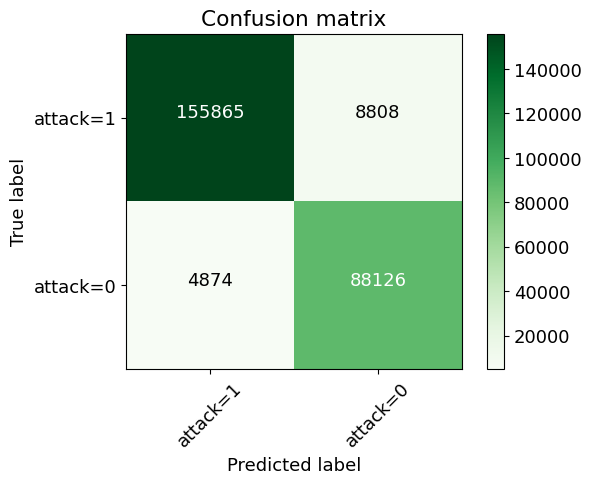

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['attack=1','attack=0'],normalize= False,  title='Confusion matrix')

In [21]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     93000
           1       0.97      0.95      0.96    164673

    accuracy                           0.95    257673
   macro avg       0.94      0.95      0.94    257673
weighted avg       0.95      0.95      0.95    257673

